In [20]:
# Credits: https://github.com/SullyChen/Autopilot-TensorFlow
#I am also trying to prepare my own dataset using OBD port of my car and a dash-cam.I will try to use Capsule nets for this purpose
#Will update the code soon.

#Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

#No.of frames produced by 25 minute of video in our dataset=25*60*30=45060 ~2.3GB of data

# Additional Installations:
# pip3 install h5py

#Additional Motivation:
#machinelearningmastery.com
#analyticsvidhya.com
#http://neuralnetworksanddeeplearning.com
#Geoffery Hinton's Series of videos on Coursera
#ConvNets by Udacity AI scholar program.




In [7]:

#To switch the backend dynamically to Theano from Tensorflow,uncomment the following code-snippet.
'''from keras import backend as K
import os

def set_keras_backend(backend):

    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("theano")'''

#Importing the requisite libraries
from __future__ import division
import os
import numpy as np
import random

from scipy import pi

#Using an iterator instead of conventional slicing techniques.
from itertools import islice

#Assigning the address of the data to TRAIN_FILE
DATA_FOLDER='./driving_dataset/'
TRAIN_FILE=os.path.join(DATA_FOLDER,'data.txt')


#We want to split the data as 80% training data and 20% testing data.
#X contains the path of the images whereas y containing the corresponding steering angle

split=0.8
X=[]
y=[]

with open(TRAIN_FILE) as fp:
    for line in islice(fp,None):
        path,angle=line.strip().split()
        full_path=os.path.join(DATA_FOLDER,path)
        X.append(full_path)
        
        y.append(float(angle)*(pi/180))

y=np.array(y)
print(y)
print('Completed processing data.txt')

split_index=int(len(y)*0.8)


train_y=y[:split_index]
test_y=y[split_index:]



[0.         0.         0.         ... 0.03874631 0.03874631 0.        ]
Completed processing data.txt


# SPLITTING OF TEMPORAL DATA

With time series data, particular care must be taken in splitting the data in order to prevent data leakage

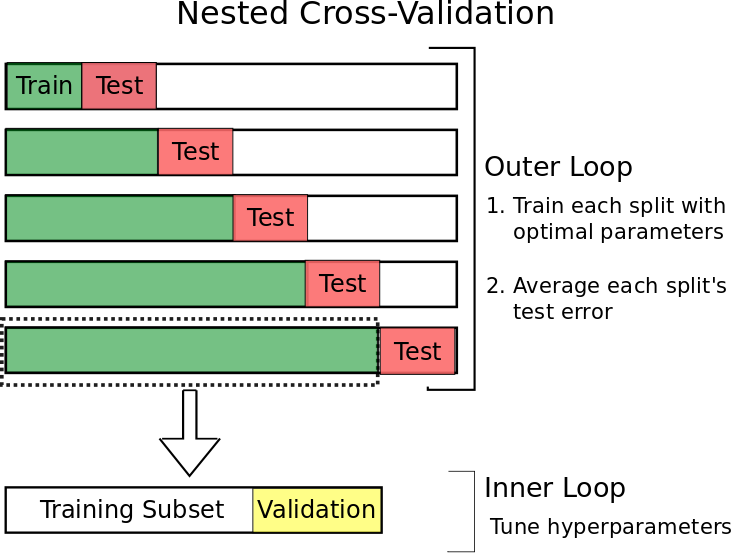

In [ ]:
#CREDITS FOR THE IMAGE:-https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9 BY Courtney Cochrane

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


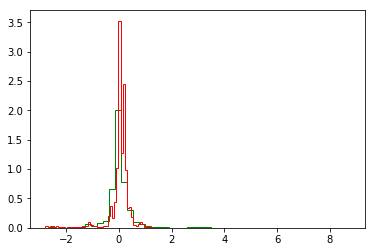

In [11]:
import numpy

import matplotlib.pyplot as plt


#Plotting a histogram to see the distribution of steering angles for both training and test data

plt.hist(train_y,bins=50,normed=1,color='green',histtype='step')
plt.hist(test_y,bins=50,normed=1,color='red',histtype='step')

plt.show()

In [14]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 

train_mean_y=np.mean(train_y)

print('Test MSE(MEAN) %f' % np.mean(np.square(test_y-train_mean_y)))
print('Test_MSE(ZERO) %f' %np.mean(np.square(test_y-0.0)))

Test MSE(MEAN) 0.191127
Test_MSE(ZERO) 0.190891


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


original image shape (256, 455, 3)
After taking the last 150 rows i.e the lower part of the image where road is visible (150, 455, 3)
After resizing the image (66, 200, 3)


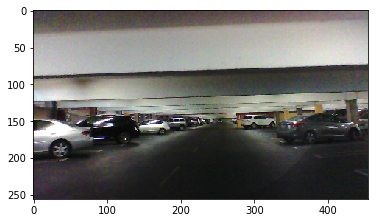

In [25]:
import scipy.misc
import random

xs=[]
ys=[]


#Batch Pointer keeps track of the batch being loaded in the memory
train_batch_pointer=0
test_batch_pointer=0

with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/"+line.split()[0])
        
        ys.append(float(line.split()[1])*scipy.pi/180)
        
num_images=len(xs)

train_xs=xs[:int(len(xs)*0.8)]
train_ys=ys[:int(len(xs)*0.8)]

test_xs=xs[-int(len(xs)*0.2 ):]
test_ys=ys[-int(len(xs)*0.2):]

num_train_images=len(train_xs)
num_test_images=len(test_xs)

#Functions to assist in loading of Training and test data
#Basic preprocessing steps such as data-normalization are also applied to the images in these functions only

def load_train_batch(batch_size):
    global train_batch_pointer
    x_out=[]
    y_out=[]
    for i in range(0,batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer+i)%num_train_images])[-150:],[66,200])/255)
        y_out.append([train_ys[(train_batch_pointer+i)%num_train_images]])
        
    train_batch_pointer+=batch_size
    return x_out_y_out

def load_test_batch(batch_size):
    global test_batch_pointer
    
    x_out=[]
    y_out=[]
    for i in range(0,batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(test_xs[(test_batch_pointer+i)%num_test_images])[-150:],[66,200])/255)
        y_out.append([test_ys[(test_batch_pointer+i)%num_test_images]])
        
    test_batch_pointer+=batch_size
    return x_out,y_out

image_read=scipy.misc.imread(train_xs[0])
print('original image shape',image_read.shape)


print('After taking the last 150 rows i.e the lower part of the image where road is visible',image_read[-150:].shape)
image_read=image_read[-150:]
resized_image=scipy.misc.imresize(image_read,[66,200])

print('After resizing the image',resized_image.shape)

#Aspect ratio is kept constant 44/150=200/66



from keras.preprocessing.image import array_to_img, img_to_array, load_img

img = load_img('driving_dataset/0.jpg')
plt.imshow(img,cmap=None)


# BUILDING THE CONVOLUTION LAYERS USING NVIDIA END TO END MODEL

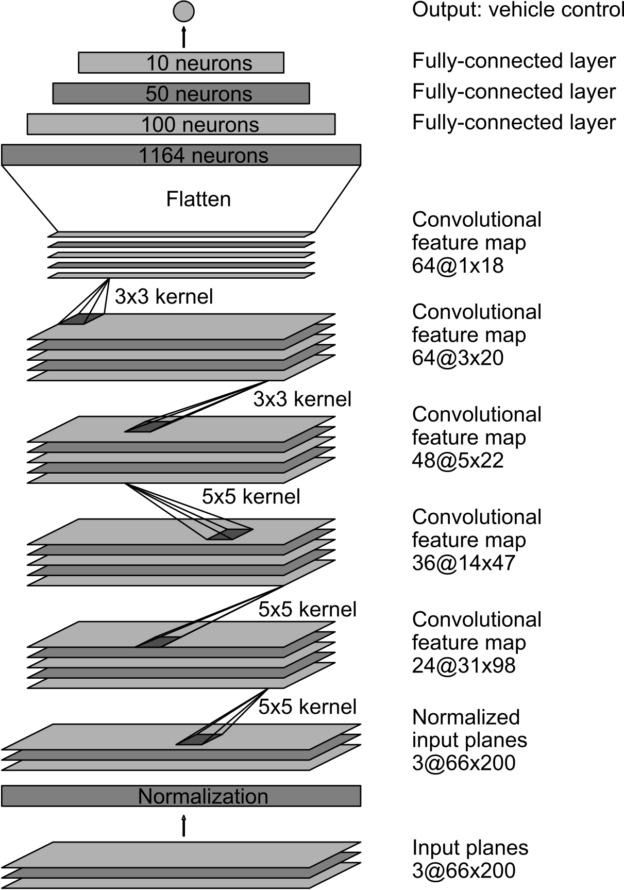

In [ ]:
#CREDITS:-https://devblogs.nvidia.com/deep-learning-self-driving-cars/

In [31]:
import tensorflow as tf
import scipy

#HELPER FUNCTION TO INITIALIZE WEIGHTS (  KERNEL ) AND BIASES

def weight_variable(shape):
    initial=tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial=tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

#HELPER FUNCTION TO CREATE CONV LAYERS

def conv2D(x,W,stride):
    return tf.nn.conv2d(x,W,strides=[1,stride,stride,1],padding='VALID')

x=tf.placeholder(tf.float32,shape=[None,66,200,3])
y_=tf.placeholder(tf.float32,shape=[None,1])

x_image=x

#Initializing the kernel size(24 kernels of size 5*5) and biases for first layer
W_conv1=weight_variable([5,5,3,24])
b_conv1=bias_variable([24])

#FIRST CONVOLUTIONAL LAYER
h_conv1=tf.nn.relu(conv2D(x_image,W_conv1,2)+b_conv1)

#SECOND CONV LAYER
W_conv2=weight_variable([5,5,24,36])
b_conv2=bias_variable([36])

h_conv2=tf.nn.relu(conv2D(h_conv1,W_conv2,2)+b_conv2)

#Third conv layer

W_conv3=weight_variable([3,3,36,48])
b_conv3=bias_variable([48])

h_conv3=tf.nn.relu(conv2D(h_conv2,W_conv3,2)+b_conv3)


#Furth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2D(h_conv3, W_conv4, 1) + b_conv4)

#Ffth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2D(h_conv4, W_conv5, 1) + b_conv5)

#Fully-Connected Layer 1

W_fc1=weight_variable([1152,1164])
b_fc1=bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y=tf.multiply(tf.atan(tf.matmul(h_fc4_drop,W_fc5)+b_fc5),2)


